## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


In [1]:
# Your code here - remember to use markdown cells for comments as well!

In [1]:
import numpy as np # linear algebra
import pandas as pd
import seaborn as sns
#import plotly.express as px
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
df_full = pd.read_csv("data\kc_house_data.csv")
df_CPI =pd.read_csv('./data/CPIAUCSL.csv')

In [3]:
#df_full =df_full[df_full['price'] < np.percentile(df_full['price'], 90)]

In [4]:
df = df_full[['id', 'sqft_lot', 'sqft_living',
                    'grade', 'condition', 'sqft_basement'
                    , 'bathrooms', 'bedrooms',
                    'date', 'waterfront', 'view', 'price', 'floors', 'zipcode', 'lat', 'long']]

df_zip = df_full[['zipcode', 'price']]
zipvalues =df_zip.groupby(['zipcode']).mean()
zipvalues = pd.DataFrame(zipvalues)

In [5]:
df_zip = pd.read_excel('data\ZIP_codes_2018.xls')
df_zip = df_zip[['ZIP Code', 'Median family income (2018)']]
df_zip

ZIP Code  Median family income (2018)
0           501                          NaN
1           544                          NaN
2           601                      14433.0
3           602                      19250.0
4           603                      19718.0
...         ...                          ...
41271     99926                      65313.0
41272     99927                          NaN
41273     99928                          NaN
41274     99929                      71923.0
41275     99950                          NaN

[41276 rows x 2 columns]

In [6]:
df_zt = df_full[['id', 'zipcode']]
zip_mult = df_zt.zipcode.replace(df_zip.set_index('ZIP Code')['Median family income (2018)'])


In [7]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

def lot_fix(x):
    if x < np.exp(7.5):
        return 1
    elif x < np.exp(10.25):
        return 2
    elif x < np.exp(12):
        return 3
    else:
        return 4

df['lot_type'] = df['sqft_lot'].apply(lot_fix)

In [8]:
df = df.drop('zipcode', 1)
df = pd.concat([df, zip_mult], axis=1)
df = df.rename(columns={'zipcode': 'zip_med_inc'})

In [9]:
df['zip_med_inc'].isna().any()

False

<AxesSubplot:xlabel='lat', ylabel='price'>

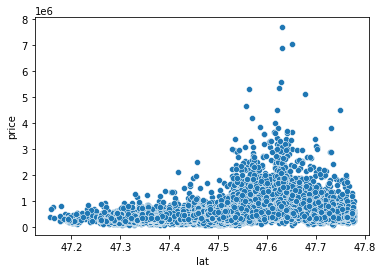

In [10]:
sns.scatterplot(x=df_full['lat'], y=df_full['price'])

<AxesSubplot:xlabel='price', ylabel='Count'>

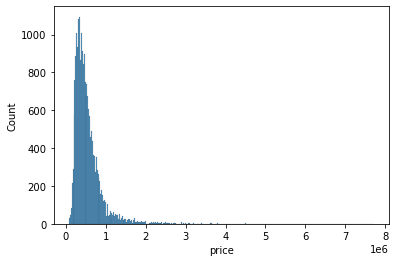

In [11]:
sns.histplot(df.price)

In [12]:
#df['lat'] = df['lat'].apply(lambda x: "{:.1f}".format(x)).astype('float64')
#df['long'] =df['long'].apply(lambda x: "{:.1f}".format(x)).astype('float64')

df['lat'] = df['lat'].apply(lambda x: abs(x - 47.6))

In [13]:
locations = df_full[['lat', 'long', 'price']]

In [14]:
dfx = locations[locations['price'] > np.percentile(locations['price'], 99.9)]

<AxesSubplot:xlabel='long', ylabel='lat'>

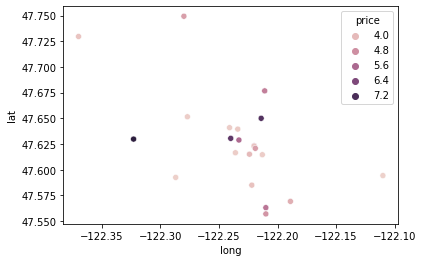

In [15]:
sns.scatterplot(x=dfx['long'], y=dfx['lat'], hue=dfx['price'])

In [16]:
df

id  sqft_lot  sqft_living  grade  condition sqft_basement  \
0      7129300520      5650         1180      7          3           0.0   
1      6414100192      7242         2570      7          3         400.0   
2      5631500400     10000          770      6          3           0.0   
3      2487200875      5000         1960      7          5         910.0   
4      1954400510      8080         1680      8          3           0.0   
...           ...       ...          ...    ...        ...           ...   
21592   263000018      1131         1530      8          3           0.0   
21593  6600060120      5813         2310      8          3           0.0   
21594  1523300141      1350         1020      7          3           0.0   
21595   291310100      2388         1600      8          3           0.0   
21596  1523300157      1076         1020      7          3           0.0   

       bathrooms  bedrooms        date  waterfront  view     price  floors  \
0           1.00         3  10/13/2014         NaN   0.0  221900.0     1.0   
1           2.25         3   12/9/2014         0.0   0.0  538000.0     2.0   
2           1.00         2   2/25/2015         0.0   0.0  180000.0     1.0   
3           3.00         4   12/9/2014         0.0   0.0  604000.0     1.0   
4           2.00         3   2/18/2015         0.0   0.0  510000.0     1.0   
...          ...       ...         ...         ...   ...       ...     ...   
21592       2.50         3   5/21/2014         0.0   0.0  360000.0     3.0   
21593       2.50         4   2/23/2015         0.0   0.0  400000.0     2.0   
21594       0.75         2   6/23/2014         0.0   0.0  402101.0     2.0   
21595       2.50         3   1/16/2015         NaN   0.0  400000.0     2.0   
21596       0.75         2  10/15/2014         0.0   0.0  325000.0     2.0   

          lat     long  zip_med_inc  
0      0.0888 -122.257      81411.0  
1      0.1210 -122.319      89351.0  
2      0.1379 -122.233     126230.0  
3      0.0792 -122.393     136917.0  
4      0.0168 -122.045     183024.0  
...       ...      ...          ...  
21592  0.0993 -122.346     134097.0  
21593  0.0893 -122.362      73989.0  
21594  0.0056 -122.299      88413.0  
21595  0.0655 -122.069     131985.0  
21596  0.0059 -122.299      88413.0  

[21597 rows x 16 columns]

In [17]:
df['view'] = df['view'].fillna(0)
df['waterfront'] = df['waterfront'].fillna(0)
df['sqft_basement'] = df['sqft_basement'].replace(to_replace='?', value= 0)

df_loc = df_full[['lat', 'long', 'price']]

fig = px.scatter_mapbox(df_loc, lat='lat', lon='long',          zoom=7, height = 600)

fig.update_layout(mapbox_style='open-street-map')
fig.show()

### row 3910

In [18]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [19]:
df_full['price'].describe()

count    2.159700e+04
mean     5.402966e+05
std      3.673681e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

pq_10 = np.percentile(df['price'], 10)
pq_25 = np.percentile(df['price'], 25)
pq_50 = np.percentile(df['price'], 50)
pq_80 = np.percentile(df['price'], 80)
pq_90 = np.percentile(df['price'], 90)

def price_cats(x):
    if x < pq_10:
        return 1
    elif x < pq_25:
        return 2
    elif x < pq_50:
        return 3
    elif x <pq_80:
        return 5
    elif x< pq_90:
        return 6
    else:
        return 7

df['price_class'] = df['price'].apply(price_cats)


0-7.5
7.5 - 10.25
10.25 - 12
12+

In [20]:
df.sqft_basement

0          0.0
1        400.0
2          0.0
3        910.0
4          0.0
         ...  
21592      0.0
21593      0.0
21594      0.0
21595      0.0
21596      0.0
Name: sqft_basement, Length: 21597, dtype: object

In [21]:

df['view'] = df['view'].astype(bool).astype(int)
df['sqft_basement'] = df['sqft_basement'].astype(bool).astype(int)

In [22]:
df.view.value_counts()

0    19485
1     2112
Name: view, dtype: int64

In [23]:
df.date

0        10/13/2014
1         12/9/2014
2         2/25/2015
3         12/9/2014
4         2/18/2015
            ...    
21592     5/21/2014
21593     2/23/2015
21594     6/23/2014
21595     1/16/2015
21596    10/15/2014
Name: date, Length: 21597, dtype: object


df['date'] = pd.to_datetime(df['date'], )
df['date'] = df['date'].apply(lambda x: x.strftime('%Y-%m'))

df_CPI['DATE'] = pd.to_datetime(df_CPI['DATE'])
df_CPI['DATE'] = df_CPI['DATE'].apply(lambda x: x.strftime('%Y-%m'))

# Make Multiplier
df_CPI['Multiplier'] = df_CPI['CPIAUCSL'].iloc[-1] / df_CPI['CPIAUCSL']

In [24]:

df1 = df[df['price'] > np.percentile(df['price'], 99)]

In [25]:
df1

id  sqft_lot  sqft_living  grade  condition  sqft_basement  \
21     2524049179     44867         3050      9          3              1   
153    7855801670     19850         5180     12          3              1   
246    2025069065      8354         3650      9          3              1   
269    7960900060     20100         5050     11          3              1   
282    7424700045      8480         3830      9          5              1   
...           ...       ...          ...    ...        ...            ...   
21352  9533100285      7965         4350     10          3              1   
21451  2311400056      8960         5230     11          3              1   
21490  2524069097    130017         7270     12          3              1   
21514  8964800330     14823         5090     11          3              1   
21560  9253900271     10584         4850     10          3              1   

       bathrooms  bedrooms       date  waterfront  view      price  floors  \
21          2.75         3  8/26/2014         0.0     1  2000000.0     1.0   
153         3.25         4   4/1/2015         0.0     1  2250000.0     2.0   
246         2.50         4  9/29/2014         1.0     1  2400000.0     1.0   
269         3.25         4   5/4/2015         0.0     1  2900000.0     1.5   
282         3.00         5  5/13/2015         0.0     1  2050000.0     2.0   
...          ...       ...        ...         ...   ...        ...     ...   
21352       3.75         4  6/30/2014         0.0     0  2070000.0     2.0   
21451       3.50         5  12/1/2014         0.0     0  1990000.0     2.0   
21490       6.50         5   5/9/2014         0.0     0  2240000.0     2.0   
21514       3.75         4   4/7/2015         0.0     0  3000000.0     1.0   
21560       4.50         5   1/7/2015         1.0     1  3570000.0     2.0   

          lat     long  zip_med_inc  
21     0.0684 -122.233     201495.0  
153    0.0380 -122.162     153243.0  
246    0.0338 -122.072     183024.0  
269    0.0312 -122.223     172560.0  
282    0.0166 -122.287     118384.0  
...       ...      ...          ...  
21352  0.0289 -122.205     172560.0  
21451  0.0036 -122.201     172560.0  
21490  0.0629 -121.982     131985.0  
21514  0.0200 -122.207     172560.0  
21560  0.0057 -122.110     125938.0  

[214 rows x 16 columns]

df = pd.merge(df, df_CPI,left_on='date', right_on='DATE', how='left')

df['price_adj'] = df['price'] * df['Multiplier']

df['Multiplier'].isna().any()

In [26]:
df.bedrooms.value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

def bed_cat(x):
    if x <=2:
        return 12
    if x <= 3:
        return 3
    if x <=4:
        return 4
    if x <= 6:
        return 56
    else:
        return 77

df['bedrooms'] = df['bedrooms'].apply(bed_cat)

df.bathrooms = df.bathrooms.round()

df.bathrooms.value_counts()

def bath_fix(x):
    if x >= 5:
        return 55
    elif x == 0:
        return 1
    else:
        return x

df['bathrooms'] = df['bathrooms'].apply(bath_fix)

In [27]:
df.bathrooms.value_counts()

2.50    5377
1.00    3851
1.75    3048
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      71
4.75      23
5.00      21
5.25      13
5.50      10
1.25       9
6.00       6
5.75       4
0.50       4
8.00       2
6.25       2
6.75       2
6.50       2
7.50       1
7.75       1
Name: bathrooms, dtype: int64

In [28]:
df.grade.value_counts(normalize=True)

7     0.415521
8     0.280826
9     0.121082
6     0.094365
10    0.052507
11    0.018475
5     0.011205
12    0.004121
4     0.001250
13    0.000602
3     0.000046
Name: grade, dtype: float64

In [29]:
df.grade = df.grade.apply(lambda x: x-3)

In [30]:
def gr_fix(x):
    if x < 5:
        return 1
    elif x < 8:
        return 2
    elif x <10:
        return 3
    else:
        return 4

In [31]:
df['grade'] = df['grade'].apply(gr_fix)

In [32]:
df.grade

0        1
1        1
2        1
3        1
4        2
        ..
21592    2
21593    2
21594    1
21595    2
21596    1
Name: grade, Length: 21597, dtype: int64

In [33]:
df_clean = df
realprice = pd.DataFrame.copy(df['price'])

In [34]:
df['price'].describe()

count    2.159700e+04
mean     5.402966e+05
std      3.673681e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

<AxesSubplot:xlabel='price', ylabel='Count'>

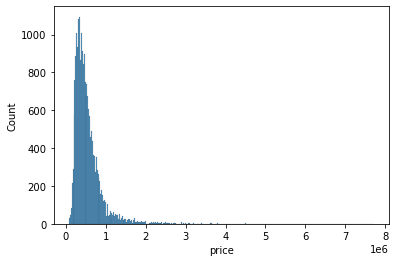

In [35]:
sns.histplot(df['price'])

In [36]:
df[['sqft_lot', 'sqft_living', 'zip_med_inc', 'bedrooms', 'bathrooms']] = np.log(df[['sqft_lot', 'sqft_living', 'zip_med_inc', 'bedrooms', 'bathrooms']])

#df['sqft_lot'] = np.log(df['sqft_lot'])
#df['sqft_living'] = np.log(df['sqft_living'])
#df['price'] = np.log(df['price'])

In [37]:
df.grade

0        1
1        1
2        1
3        1
4        2
        ..
21592    2
21593    2
21594    1
21595    2
21596    1
Name: grade, Length: 21597, dtype: int64

In [38]:
#zip_dummies = pd.get_dummies(df['zipcode'], prefix='zipcode', drop_first=True)
#pc_dummies = pd.get_dummies(df['price_class'], prefix='price_class', drop_first=True)
grade_dummies = pd.get_dummies(df['grade'], prefix='grade', drop_first=True)
cond_dummies = pd.get_dummies(df['condition'], prefix='cond', drop_first=True)
# = pd.get_dummies(df['lot_type'], prefix ='lot_size' , drop_first= True)   
#view_dummies =pd.get_dummies(df['view'], prefix ='view' , drop_first= True)
#bed_dummies =  pd.get_dummies(df['bedrooms'], prefix='bed', drop_first=True)
#bath_dummies =  pd.get_dummies(df['bathrooms'], prefix='bath', drop_first=True)

df = df.drop([ 'grade', 'condition'], axis=1)



df = pd.concat([df, grade_dummies, cond_dummies], axis=1)


In [39]:
df.head(20)

id   sqft_lot  sqft_living  sqft_basement  bathrooms  bedrooms  \
0   7129300520   8.639411     7.073270              1   0.000000  1.098612   
1   6414100192   8.887653     7.851661              1   0.810930  1.098612   
2   5631500400   9.210340     6.646391              1   0.000000  0.693147   
3   2487200875   8.517193     7.580700              1   1.098612  1.386294   
4   1954400510   8.997147     7.426549              1   0.693147  1.098612   
5   7237550310  11.532042     8.597851              1   1.504077  1.386294   
6   1321400060   8.827468     7.447168              0   0.810930  1.098612   
7   2008000270   9.181015     6.966024              1   0.405465  1.098612   
8   2414600126   8.918650     7.484369              1   0.000000  1.098612   
9   3793500160   8.788746     7.544332              1   0.916291  1.098612   
10  1736800520   9.189729     8.177516              1   0.916291  1.098612   
11  9212900260   8.699515     7.056175              1   0.000000  0.693147   
12   114101516   9.898525     7.265430              1   0.000000  1.098612   
13  6054650070   9.177817     7.222566              1   0.559616  1.098612   
14  1175000570   8.486734     7.501082              1   0.693147  1.609438   
15  9297300055   8.517193     7.989560              1   1.098612  1.386294   
16  1875500060   9.549666     7.544332              1   0.693147  1.098612   
17  6865200140   8.366370     7.377759              1   0.000000  1.386294   
18    16000397   9.195227     7.090077              0   0.000000  0.693147   
19  7983200060   9.187481     7.130899              1   0.000000  1.098612   

          date  waterfront  view      price  ...     lat     long  \
0   10/13/2014         0.0     0   221900.0  ...  0.0888 -122.257   
1    12/9/2014         0.0     0   538000.0  ...  0.1210 -122.319   
2    2/25/2015         0.0     0   180000.0  ...  0.1379 -122.233   
3    12/9/2014         0.0     0   604000.0  ...  0.0792 -122.393   
4    2/18/2015         0.0     0   510000.0  ...  0.0168 -122.045   
5    5/12/2014         0.0     0  1230000.0  ...  0.0561 -122.005   
6    6/27/2014         0.0     0   257500.0  ...  0.2903 -122.327   
7    1/15/2015         0.0     0   291850.0  ...  0.1905 -122.315   
8    4/15/2015         0.0     0   229500.0  ...  0.0877 -122.337   
9    3/12/2015         0.0     0   323000.0  ...  0.2316 -122.031   
10    4/3/2015         0.0     0   662500.0  ...  0.0007 -122.145   
11   5/27/2014         0.0     0   468000.0  ...  0.0900 -122.292   
12   5/28/2014         0.0     0   310000.0  ...  0.1558 -122.229   
13   10/7/2014         0.0     0   400000.0  ...  0.0127 -122.045   
14   3/12/2015         0.0     0   530000.0  ...  0.0700 -122.394   
15   1/24/2015         0.0     1   650000.0  ...  0.0286 -122.375   
16   7/31/2014         0.0     0   395000.0  ...  0.1277 -121.962   
17   5/29/2014         0.0     0   485000.0  ...  0.0648 -122.343   
18   12/5/2014         0.0     0   189000.0  ...  0.2911 -122.210   
19   4/24/2015         0.0     0   230000.0  ...  0.2657 -122.306   

    zip_med_inc  grade_2  grade_3  grade_4  cond_2  cond_3  cond_4  cond_5  
0     11.307266        0        0        0       0       1       0       0  
1     11.400328        0        0        0       0       1       0       0  
2     11.745861        0        0        0       0       1       0       0  
3     11.827130        0        0        0       0       0       0       1  
4     12.117373        1        0        0       0       1       0       0  
5     11.973497        0        1        0       0       1       0       0  
6     11.052143        0        0        0       0       1       0       0  
7     11.207894        0        0        0       0       1       0       0  
8     11.211672        0        0        0       0       1       0       0  
9     11.658488        0        0        0       0       1       0       0  
10    11.564892        1        0        0       0       1       0       0  

In [40]:
df = df.drop(['id', 'date'], axis= 1)

In [41]:
df[df.isna().any(axis=1)]

Empty DataFrame
Columns: [sqft_lot, sqft_living, sqft_basement, bathrooms, bedrooms, waterfront, view, price, floors, lat, long, zip_med_inc, grade_2, grade_3, grade_4, cond_2, cond_3, cond_4, cond_5]
Index: []

In [42]:
price_log = np.log(df.price)
price_log = pd.DataFrame(price_log)

In [43]:
df.sqft_basement.describe()

count    21597.000000
mean         0.978979
std          0.143459
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: sqft_basement, dtype: float64

In [44]:
df.waterfront = df.waterfront.fillna(0)

df = df.drop('DATE', 1)

<AxesSubplot:ylabel='Count'>

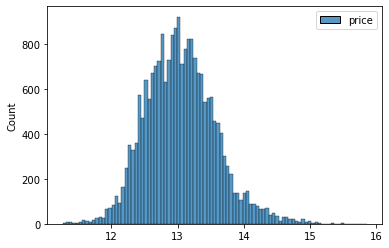

In [45]:
sns.histplot(price_log)

In [46]:
X = df.drop('price', 1)
y =price_log

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

In [48]:
scaler = StandardScaler()
scalerp = StandardScaler()

X_train[['sqft_living', 'sqft_lot', 'lat', 'long', 'zip_value', 'floors', 'bedrooms', 'bathrooms']] =scaler.fit_transform(X_train[['sqft_living', 'sqft_lot', 'lat', 'long', 'zip_med_inc', 'floors', 'bedrooms', 'bathrooms']])


X_test[['sqft_living', 'sqft_lot', 'lat', 'long', 'zip_value', 'floors', 'bedrooms', 'bathrooms']] = scaler.transform(X_test[['sqft_living', 'sqft_lot', 'lat', 'long', 'zip_med_inc', 'floors', 'bedrooms', 'bathrooms']])


y_train = scalerp.fit_transform(pd.DataFrame(y_train))
y_test = scalerp.transform(pd.DataFrame(y_test))
print(y_train)

[[-0.88333667]
 [ 0.31780766]
 [ 1.63274215]
 ...
 [ 2.27104663]
 [ 0.49861579]
 [-0.63123954]]
C:\Users\saifw\anaconda3\lib\site-packages\pandas\core\indexing.py:659: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[k] = np.nan
<ipython-input-48-fac8cb2693c6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['sqft_living', 'sqft_lot', 'lat', 'long', 'zip_value', 'floors', 'bedrooms', 'bathrooms']] =scaler.fit_transform(X_train[['sqft_living', 'sqft_lot', 'lat', 'long', 'zip_med_inc', 'floors'

In [49]:
predictors = sm.add_constant(X_train)
model_1 = sm.OLS(y_train , predictors).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     4462.
Date:                Mon, 15 Mar 2021   Prob (F-statistic):               0.00
Time:                        00:40:04   Log-Likelihood:                -9549.7
No. Observations:               17277   AIC:                         1.914e+04
Df Residuals:                   17258   BIC:                         1.928e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0151      0.001    -20.755      0.000      -0.017      -0.014
sqft_lot          0.0917      0.004     21.594      0.000       0.083       0.100
sqft_living       0.4381      0.007     66.202      0.000       0.425       0.451
sqft_basement    -0.0120      0.022     -0.538      0.590      -0.056       0.032
bathrooms         0.0296      0.005      5.394      0.000       0.019       0.040
bedrooms         -0.0426      0.004     -9.754      0.000      -0.051      -0.034
waterfront        0.9053      0.040     22.517      0.000       0.826       0.984
view              0.3213      0.012     27.253      0.000       0.298       0.344
floors            0.0352      0.004      8.339      0.000       0.027       0.043
lat              -0.2697      0.004    -66.478      0.000      -0.278      -0.262
long             -0.1913      0.004    -50.066      0.000      -0.199      -0.184
zip_med_inc      -0.0650      0.008     -8.409      0.000      -0.080      -0.050
grade_2           0.2198      0.009     25.116      0.000       0.203       0.237
grade_3           0.7501      0.025     29.786      0.000       0.701       0.799
grade_4           1.6442      0.134     12.238      0.000       1.381       1.907
cond_2            0.2444      0.095      2.568      0.010       0.058       0.431
cond_3            0.6009      0.088      6.824      0.000       0.428       0.774
cond_4            0.6644      0.088      7.540      0.000       0.492       0.837
cond_5            0.7933      0.089      8.947      0.000       0.620       0.967
zip_value         0.3780      0.005     78.861      0.000       0.369       0.387
==============================================================================
Omnibus:                      486.609   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1205.058
Skew:                           0.077   Prob(JB):                    2.11e-262
Kurtosis:                       4.285   Cond. No.                     1.09e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.01e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [50]:
linreg= LinearRegression()
linreg.fit(X_train, y_train)

# make predictions
y_hat = linreg.predict(X_test)
y_hat = scalerp.inverse_transform(y_hat)

y_hat = np.exp(y_hat)
y_hat


array([[1051320.13987014],
       [ 317156.34629244],
       [ 351549.59345792],
       ...,
       [ 444562.35291337],
       [ 263505.48327041],
       [1038411.28901048]])

In [51]:

scores = cross_val_score(
            linreg, 
            X_train,
            y_train,
            cv=8,
            scoring="neg_mean_squared_error")



rmse_scores = np.sqrt(-scores)
display(rmse_scores.mean())
display(rmse_scores.std())

0.421155904911261

0.0054862695158135405

In [52]:


scores2 = cross_val_score(
            linreg, 
            X_test,
            y_test,
            cv=8,
            scoring="neg_mean_squared_error"
)

rmse_scores2 = np.sqrt(-scores2)

display(rmse_scores2.mean())
display(rmse_scores2.std())

0.4197337147235193

0.012201151755520586

In [53]:
X2 = df.drop(['sqft_lot', 'sqft_basement', 'bedrooms', 'bathrooms', 'floors', 'cond_2', 'cond_3', 'price'], 1)
y2 =price_log

In [54]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=11)

In [55]:
scaler2 = StandardScaler()
scalerp2 = StandardScaler()

X_train2[['sqft_living', 'lat', 'long', 'zip_med_inc']] = scaler2.fit_transform(X_train2[['sqft_living', 'lat', 'long','zip_med_inc']])


X_test2[['sqft_living','lat', 'long', 'zip_med_inc']] = scaler2.transform(X_test2[['sqft_living', 'lat', 'long','zip_med_inc']])

y_train2 = scalerp2.fit_transform(pd.DataFrame(y_train2))
y_test2 = scalerp2.transform(pd.DataFrame(y_test2))

<ipython-input-55-aaf2069c2da3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train2[['sqft_living', 'lat', 'long', 'zip_med_inc']] = scaler2.fit_transform(X_train2[['sqft_living', 'lat', 'long','zip_med_inc']])
C:\Users\saifw\anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
<ipython-input-55-aaf2069c2da3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [56]:
y_train2

array([[-0.88333667],
       [ 0.31780766],
       [ 1.63274215],
       ...,
       [ 2.27104663],
       [ 0.49861579],
       [-0.63123954]])

In [57]:
predictors = sm.add_constant(X_train2)
model_2 = sm.OLS(y_train2 , predictors).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     6971.
Date:                Mon, 15 Mar 2021   Prob (F-statistic):               0.00
Time:                        00:40:05   Log-Likelihood:                -9881.5
No. Observations:               17277   AIC:                         1.979e+04
Df Residuals:                   17265   BIC:                         1.988e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.2053      0.006    -33.990      0.000      -0.217      -0.193
sqft_living     0.4596      0.004    105.004      0.000       0.451       0.468
waterfront      0.9761      0.041     23.892      0.000       0.896       1.056
view            0.3435      0.012     28.846      0.000       0.320       0.367
lat            -0.2483      0.004    -61.901      0.000      -0.256      -0.240
long           -0.1608      0.004    -44.441      0.000      -0.168      -0.154
zip_med_inc     0.3635      0.004     84.429      0.000       0.355       0.372
grade_2         0.2436      0.008     28.975      0.000       0.227       0.260
grade_3         0.8459      0.025     33.693      0.000       0.797       0.895
grade_4         1.7511      0.137     12.803      0.000       1.483       2.019
cond_4          0.0735      0.008      9.619      0.000       0.058       0.088
cond_5          0.1934      0.013     15.445      0.000       0.169       0.218
==============================================================================
Omnibus:                      540.929   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1338.174
Skew:                           0.126   Prob(JB):                    2.62e-291
Kurtosis:                       4.340   Cond. No.                         56.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [58]:
linreg2= LinearRegression()
linreg2.fit(X_train2, y_train)

# make predictions
y_hat2 = linreg2.predict(X_test2)
sss = y_hat2
y_hat2 = scalerp2.inverse_transform(y_hat2)

y_hat2 = np.exp(y_hat2)
y_hat2

array([[1071061.92324239],
       [ 323840.51374811],
       [ 347111.8429968 ],
       ...,
       [ 397207.65251913],
       [ 268415.85988549],
       [ 991959.51596385]])

In [59]:
scores4 = cross_val_score(
            linreg2, 
            X_train2,
            y_train2,
            cv=8,
            scoring="neg_mean_squared_error"
)

rmse_scores4 = np.sqrt(-scores4)

display(rmse_scores4.mean())

0.4289820711788773

In [60]:
scores3 = cross_val_score(
            linreg2, 
            X_test2,
            y_test2,
            cv=8,
            scoring="neg_mean_squared_error"
)

rmse_scores3 = np.sqrt(-scores3)

display(rmse_scores3.mean())

0.4236300142516134

In [61]:
y_hat_train = linreg2.predict(X_train2)
y_hat_test = linreg2.predict(X_test2)



y_train2 = scalerp.inverse_transform(y_train2)
y_test2 = scalerp.inverse_transform(y_test2)
y_hat_train = scalerp.inverse_transform(y_hat_train)
y_hat_test = scalerp.inverse_transform(y_hat_test)


resids = y_hat_test - y_test2

y_train2 = np.exp(y_train2)
y_test2 = np.exp(y_test2)
y_hat_train = np.exp(y_hat_train)
y_hat_test = np.exp(y_hat_test)

train_rmse = np.sqrt(mean_squared_error(y_train2, y_hat_train))
test_rmse = np.sqrt(mean_squared_error(y_test2, y_hat_test))

test_mae = mean_absolute_error(y_test2, y_hat_test)

In [72]:
train_mae = mean_absolute_error(y_train2, y_hat_train)

In [62]:
display(train_rmse)
display(test_rmse)

169224.51306513356

151864.70664971956

In [73]:
print(test_mae)
print(train_mae)

93100.46349332073
96383.84982516189


In [63]:
resids

array([[-0.12196975],
       [-0.05747929],
       [ 0.08445594],
       ...,
       [ 0.05753317],
       [-0.18046005],
       [-0.64992687]])

<AxesSubplot:ylabel='Count'>

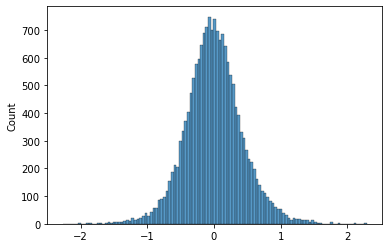

In [64]:
sns.histplot(model_2.resid)

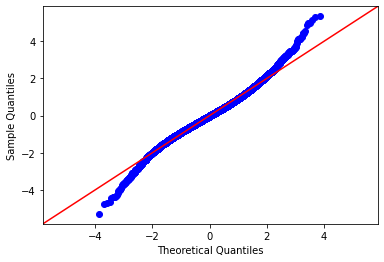

In [65]:
import scipy.stats as stats
fig = sm.graphics.qqplot(model_2.resid, dist=stats.norm, line='45', fit=True)


<AxesSubplot:>

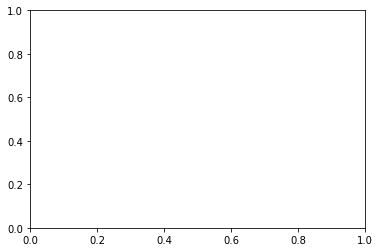

In [66]:
sns.histplot()

In [67]:
df_full.duplicated(subset=None, keep='first')

0        False
1        False
2        False
3        False
4        False
         ...  
21592    False
21593    False
21594    False
21595    False
21596    False
Length: 21597, dtype: bool

In [68]:


cv_5_results  = np.mean(cross_val_score(linreg2, X2, y2, cv=5,  scoring='neg_mean_squared_error'))
cv_10_results = np.mean(cross_val_score(linreg2, X2, y2, cv=10, scoring='neg_mean_squared_error'))
cv_20_results = np.mean(cross_val_score(linreg2, X2, y2, cv=20, scoring='neg_mean_squared_error'))


mae = np.mean(cross_val_score(linreg2, X2, y2, cv=5,  scoring='neg_mean_absolute_error'))

In [69]:
print(np.sqrt(-cv_5_results))
print(np.sqrt(-cv_10_results))
print(np.sqrt(-cv_20_results))


0.22581992907757859
0.22580067837410125
0.22567049060478464


In [70]:
print(-mae)

0.17211123141363277
